In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<p> First, we load the dataset and apply some pre-processing techniques shown in previous sections </p>

In [3]:
df = pd.read_csv("Dataset - Group 50 - Data - New.csv")
df = df.iloc[:158]
df.drop(['Add columns here', 'Add columns here.1', 'Add columns here.2', 'Reviewer', 'Review'], axis = 1, inplace = True)
df.drop(['Account bio', 'Tweet Translated', 'Views', 'Remarks', 'Location', 'Reasoning', 'Screenshot'], axis = 1, inplace = True)
df['Quote Tweets'].fillna(0, inplace = True)
df['Replies'].fillna(0, inplace = True)
df['Rating'].fillna('FALSE', inplace = True)
df['Date posted'] = pd.to_datetime(df['Date posted'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Rating'] = df['Rating'].replace('FALSE. MISLEADING', 'FALSE, MISLEADING')
df['Followers'] = df['Followers'].replace('28.3K', '28,300')
df['Followers'] = df['Followers'].replace('20.4K', '20,300')

C:\Users\Fort Bueno\AppData\Local\Temp\ipykernel_24216\2151456633.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date posted'] = pd.to_datetime(df['Date posted'])
C:\Users\Fort Bueno\AppData\Local\Temp\ipykernel_24216\2151456633.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


In [4]:
from calendar import month_name as mn
import matplotlib.dates as mdates
import numpy as np

grouped_df = df.groupby('Date posted').size().reset_index(name='count')
grouped_df.set_index(['Date posted'], inplace = True)
count_monthly = grouped_df[['count']].resample('M').sum()  #resample by months
count_monthly.reset_index(inplace=True)

count_monthly['count'] = count_monthly['count'].replace(0, np.NaN)
count_monthly['count_linear'] = count_monthly['count'].interpolate(method='linear')
count_monthly['count'] = count_monthly['count'].replace(np.NaN, 0)

count_monthly.head()

,Date posted,count,count_linear
0,2016-03-31,1.0,1.0
1,2016-04-30,1.0,1.0
2,2016-05-31,0.0,1.0
3,2016-06-30,0.0,1.0
4,2016-07-31,0.0,1.0


<p> Divide the data set into pre-election and election period</p>

In [5]:
cutoff_date = pd.to_datetime('2022-01-09')
pre_election = count_monthly[count_monthly['Date posted'] < cutoff_date]
election = count_monthly[count_monthly['Date posted'] >= cutoff_date]
print(pre_election.shape)
print(election.shape)

(70, 3)
(12, 3)


<p> Perform Shapiro-Wilk Test for normality </p>

In [6]:
from scipy.stats import shapiro

pre_elec_statistic, pre_elec_p_val = shapiro(pre_election['count_linear'])
elec_statistic, elec_p_val = shapiro(election['count_linear'])
print(f"Pre election statistic: {pre_elec_statistic} , Pre election p-value: {pre_elec_p_val}")
print(f"Elec statistic: {elec_statistic} , Elec p-value: {elec_p_val}")

Pre election statistic: 0.6474336981773376 , Pre election p-value: 1.0999267469058438e-11
Elec statistic: 0.8453301191329956 , Elec p-value: 0.03216327726840973


<p> Since both pre-election and election periods have a p-value of less than the significance level of 0.05, we reject the null hypothesis of the Shapiro-Wilk Test for both. Thus, the samples from both periods do not follow a normal distribution. This means that we cannot perform an independent samples t-test because we fail onee of its assumptions which is normality of data. Hence, we now use a non-parametric test, specifically a Mann-Whitney U-Test

<p> We check the assumptions for the Mann-Whitney U-test: https://statistics.laerd.com/statistical-guides/mann-whitney-u-test-assumptions.php</p>

<p> For assumption#1, we indeed have one dependent variable that is measured at the continuous or ordinal level which is the frequency of tweets named count_linear.

In [7]:
print("Pre-election:")
print(pre_election['count_linear'].head())
print("Election:")
print(election['count_linear'].head())

Pre-election:
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: count_linear, dtype: float64
Election:
70    1.0
71    1.0
72    1.0
73    3.0
74    7.0
Name: count_linear, dtype: float64


<p> For assumption#2, we have one independent variable (Date posted) that consists of two categorical, independent groups (pre-election and election period).

For assumption#3, we have independence of observations, which means that there is no relationship between the observations in each group of the independent variable or between the groups themselves.

In [8]:
#we already know that the two periods have different dates since we have divided the dataset earlier
#check for any duplicates in the dates posted in each period
print(f"pre-election dates duplicates: {pre_election['Date posted'].duplicated().sum()}")
print(f"election dates duplicates: {election['Date posted'].duplicated().sum()}")

pre-election dates duplicates: 0
election dates duplicates: 0


For assumption#4, we check if the distributions have the same shape by plotting a histogram

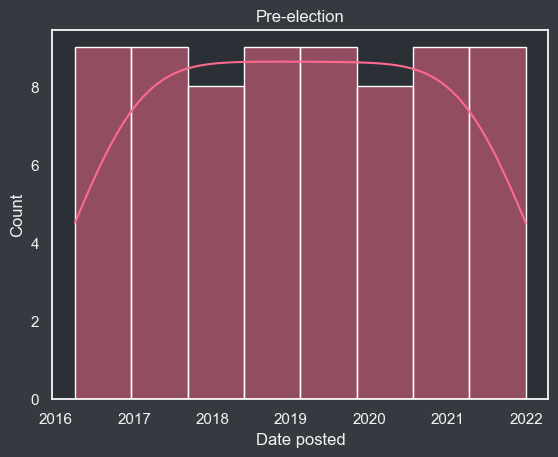

In [14]:
sns.set(rc={'axes.facecolor':'#2a3035','axes.grid': False, 'figure.facecolor': '#343a3f', 'xtick.color': '#f3f3f3', 'ytick.color': '#f3f3f3', 'text.color': '#f3f3f3', 'axes.labelcolor': '#f3f3f3'})
sns.histplot(pre_election['Date posted'].dropna(), kde=True, color ='#fd6a8d').set_title('Pre-election')
plt.show()

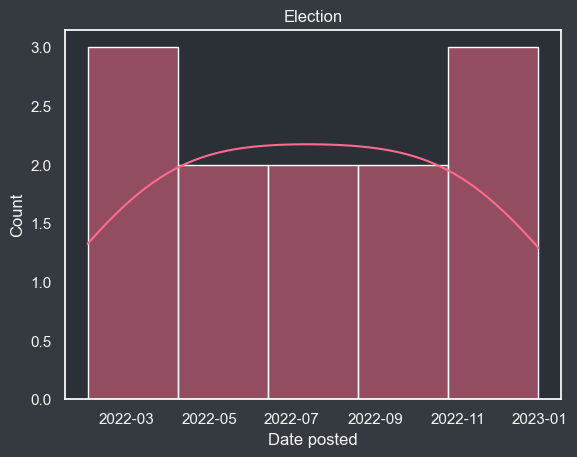

In [15]:
sns.set(rc={'axes.facecolor':'#2a3035','axes.grid': False, 'figure.facecolor': '#343a3f', 'xtick.color': '#f3f3f3', 'ytick.color': '#f3f3f3', 'text.color': '#f3f3f3', 'axes.labelcolor': '#f3f3f3'})
sns.histplot(election['Date posted'].dropna(), kde=True, color ='#fd6a8d').set_title('Election')
plt.show()

<p> We now proceed to perform the Mann-Whitney U Test since we have validated all the assumptions for the said test </p

In [11]:
from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(pre_election['count_linear'], election['count_linear'], alternative = 'two-sided')

# Output the test results
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Mann-Whitney U statistic: 309.0
p-value: 0.13213040911795965


In [12]:
#linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm

# Convert datetime to int
x = pre_election['Date posted'].astype('int64') / 10**9  # Convert to seconds (UNIX epoch start)
x = x.values.reshape(-1, 1)

y = pre_election['count_linear']

o = election['Date posted'].astype('int64') / 10**9
o = o.values.reshape(-1, 1)
f = election['count_linear']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

o_lms = sm.add_constant(o)
linear_model_stat_elec = sm.OLS(f, o_lms)
lms_results_elec = linear_model_stat_elec.fit()
p_values_elec = lms_results_elec.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)
Slope = linear_model.coef_[1]

linear_model_elec = LinearRegression()
linear_model_elec.fit(o_lms, f)
f_linear_pred = linear_model_elec.predict(o_lms)
Slope_elec = linear_model_elec.coef_[1]

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

linear_r2_elec = r2_score(f, f_linear_pred)
linear_rmse_elec = np.sqrt(mean_squared_error(f, f_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse_elec, linear_r2_elec))
for j, p_value_elec in enumerate(p_values_elec.index):
  print(f'P({p_value_elec}): {p_values_elec[j]}')

if any(p_values_elec <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n") 


print("The slope of the regression model is: ", Slope)
print("The slope of the regression model is: ", Slope_elec)

# Plot the model
import plotly.graph_objects as go

xtt = pre_election['Date posted'].dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='#333333', opacity=0.7))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='#66E5CC', dash='dash', width = 4))

xtt_elec = election['Date posted'].dt.strftime('%Y-%m-%d')
scatter_actual_elec = go.Scatter(x=xtt_elec, y=f, mode='markers', name='Actual', marker=dict(color='#73bbd4', opacity=1))

line_regression_elec = go.Scatter(x=xtt_elec, y=f_linear_pred, mode='lines', name='LR', line=dict(color='#dfb0b0', width=4) )

data = [scatter_actual, line_regression, scatter_actual_elec, line_regression_elec]

layout = go.Layout(xaxis=dict(title='<b>Date</b>'),
                   yaxis=dict(title='<b>Tweet Count</b>'),
                   title='<b>Linear Regression Model for Risa Tweets Count</b>',
                   showlegend=True,
                   height=600,
                   plot_bgcolor="#f8f8f8")


fig = go.Figure(data=data, layout=layout)
fig.add_vline(x = '2021-12-31', line_width = 3, line_dash = 'dot', line_color = '#333333')


fig.show()

Model Evaluation

Linear Regression: RMSE=2.03, R2=0.10
P(x1): 0.008443919444287644
There is a significant relationship between the predictor and the response

Model Evaluation

Linear Regression: RMSE=2.56, R2=0.10
P(x1): 0.3292329790507019
There is no significant relationship between the predictor and the response

The slope of the regression model is:  1.2548624950392943e-08
The slope of the regression model is:  9.131352114830151e-08


In [13]:
## Perform regression modeling
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Convert datetime to int
x = count_monthly['Date posted'].astype(np.int64) / 10**9  # Convert to seconds (UNIX epoch start)
x = x.values.reshape(-1, 1)

y = count_monthly['count_linear']


#--------------------------------------------------------------
# SVR model with hyperparameter optimization
#--------------------------------------------------------------
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Create a pipeline with StandardScaler and SVR
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('svr', SVR(kernel='rbf'))])

# Define the parameter grid for hyperparameter optimization
# param_grid = {'svr__C': [10000, 1000000, 100],
#               'svr__gamma': [10, 1000, 100]}
param_grid = {'svr__C': [100, 1000, 100],
              'svr__gamma': [1, 1000, 100]}

# Perform grid search with cross-validation on train data
grid_search = GridSearchCV(pipeline, param_grid)
grid_search.fit(x_train, y_train)

# Predict using best model on test data
best_svr = grid_search.best_estimator_
y_svr_pred_test = best_svr.predict(x_test)


# Calculate R2 and RMSE for SVR model
svr_r2 = r2_score(y_test, y_svr_pred_test)
svr_rmse = np.sqrt(mean_squared_error(y_test, y_svr_pred_test))

print("Model Evaluation")
print("\nSupport Vector Regression: RMSE=%.2f, R2=%.2f" % (svr_rmse, svr_r2))
print("Hyperparameters:", best_svr, "\n")

# Plot the model
import plotly.graph_objects as go

xtt = count_monthly['Date posted'].dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='#73bbd4', opacity=1))


line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='#FF5E84', dash='dash', width = 4))

y_svr_pred = best_svr.predict(x) # Plot on all data
line_svr = go.Scatter(x=xtt, y=y_svr_pred, mode='lines', name='SVR', line=dict(color='#f3f3f3', width = 4))

data = [scatter_actual, line_regression, line_regression_elec, line_svr]

layout = go.Layout(xaxis=dict(title='<b>Date</b>', color = "#f3f3f3"),
                   yaxis=dict(title='<b>Tweet Count</b>', color = "#f3f3f3"),
                   title = '<span style = "color:#f3f3f3">Linear Regression vs. SVR for Tweet Frequency of Risa Hontiveros Philhealth Allegations </span>',
                   showlegend=True,
                   height=600,
                   plot_bgcolor="#2A3035",
                   paper_bgcolor="#31373E",
                   font_color = "#f3f3f3")


print("The slope of the regression model is: ", Slope)

fig = go.Figure(data=data, layout=layout)
fig.add_vline(x = '2021-12-31', line_width = 5, line_dash = 'dot', line_color = '#66E5CC')
fig.show()

Model Evaluation

Support Vector Regression: RMSE=2.75, R2=0.06
Hyperparameters: Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR(C=100, gamma=1000))]) 

The slope of the regression model is:  1.2548624950392943e-08
